# 6.5 Unsupervised Machine Learning - Clustering 

## Outline

### 1. Import Libraries and Data
- data check and cleaning
- remove categorical columns
- standardize data  so it isn't on different scales

### 2. Elbow technique
 - Determine optimal number of clusters

### 3. k-means clustering
 - run k-means algorithm
 - add new column with resulting clusters
 - create visualizations with clustered data
 - discuss 

### 4. Descriptive statistics - clusters 
 - Discuss 
 
### 5. Add cluster data and export

### 1 Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans
import pylab as pl 
from sklearn.preprocessing import StandardScaler #used to standardize data

In [2]:
# Set the option to display graphs within the notebook.

%matplotlib inline

In [3]:
#Define file path

path = r'C:\Users\Caroline\Documents\Career Foundry\06 2023 EVCS washington state'

In [4]:
# Import data

df_present = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'WA_present.pkl'))
df_hist = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'WA_hist.pkl'))

In [5]:
#Check data and clean
df_hist.shape

(3203, 17)

In [6]:
df_present.shape

(1902, 25)

In [7]:
df_present.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1902 entries, 0 to 1901
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Station Name     1900 non-null   object        
 1   City             1900 non-null   object        
 2   County           1902 non-null   object        
 3   Latitude         1900 non-null   float64       
 4   Longitude        1900 non-null   float64       
 5   EV Level1        1902 non-null   int32         
 6   EV Level2        1902 non-null   int32         
 7   EV Level3        1902 non-null   int32         
 8   Open Date2       1900 non-null   datetime64[ns]
 9   evcs_sum         1902 non-null   int32         
 10  L3cs_sum_county  1900 non-null   float64       
 11  L3port present   1900 non-null   object        
 12  CountyPop_90     1902 non-null   int64         
 13  CountyPop_00     1902 non-null   int64         
 14  CountyPop_10     1902 non-null   int64  

In [8]:
#Visual check of df_present
df_present. head()

,Station Name,City,County,Latitude,Longitude,EV Level1,EV Level2,EV Level3,Open Date2,evcs_sum,...,CountyPop_20,CountyPop_22,Area sq mi,popdensity,density flag,00-20 popchange,20-22 popchange,EV_co_curr,Year,Month
0,Best Western Plus Bronco Inn - Tesla Supercharger,Ritzville,Adams,47.116294,-118.368328,0,0,4,2014-06-15,3,...,20612,20961,1924.977566,10.707657,low density,4186,349,39,2014,6
1,Cow Creek Mercantile,Ritzville,Adams,47.119480,-118.362710,0,0,4,2019-08-22,3,...,20612,20961,1924.977566,10.707657,low density,4186,349,39,2019,8
2,Conoco,Ritzville,Adams,47.118605,-118.365561,0,0,1,2018-03-07,3,...,20612,20961,1924.977566,10.707657,low density,4186,349,39,2018,3
3,Port of Clarkston,Clarkston,Asotin,46.425498,-117.048650,0,2,0,2017-05-01,1,...,22288,22508,636.212991,35.032293,low density,1735,220,55,2017,5
4,Hamilton Cellars - Tesla Destination,Benton City,Benton,46.296071,-119.451487,0,3,0,2015-07-14,20,...,206875,212791,1700.379029,121.664050,medium density,64402,5916,1687,2015,7


Hypotheses 
- Hyp 3 - Counties with denser populations have higher rates of EV ownership - X = population density, y = Rate of EV ownership 
- Hyp 2 - % of EV registrations has increased over time - X = time, y = %of EV of vehicle registrations - clustering counties to make sense of data from Task 6.4?

In [9]:
#My goal is to try and determine how the counties could be clustered 
#To do this the df_present will be used & simplified to one row per county.

#Create a new df without duplicate county entries
df_present_unique = df_present.drop_duplicates(subset=['County'], keep='first')

In [10]:
df_present_unique.shape

(39, 25)

In [11]:
df_present_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 0 to 1871
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Station Name     37 non-null     object        
 1   City             37 non-null     object        
 2   County           39 non-null     object        
 3   Latitude         37 non-null     float64       
 4   Longitude        37 non-null     float64       
 5   EV Level1        39 non-null     int32         
 6   EV Level2        39 non-null     int32         
 7   EV Level3        39 non-null     int32         
 8   Open Date2       37 non-null     datetime64[ns]
 9   evcs_sum         39 non-null     int32         
 10  L3cs_sum_county  37 non-null     float64       
 11  L3port present   37 non-null     object        
 12  CountyPop_90     39 non-null     int64         
 13  CountyPop_00     39 non-null     int64         
 14  CountyPop_10     39 non-null     int64    

In [12]:
# Select numeric columns for clustering
selected_columns = ['evcs_sum', '00-20 popchange', 'popdensity', 'CountyPop_22', 'EV_co_curr', 'L3cs_sum_county']


In [13]:
# Create a new DataFrame containing only the selected columns
df_selected = df_present_unique[selected_columns]

In [14]:
df_selected 

,evcs_sum,00-20 popchange,popdensity,CountyPop_22,EV_co_curr,L3cs_sum_county
0,3,4186,10.707657,20961,39,9.0
3,1,1735,35.032293,22508,55,0.0
4,20,64402,121.664050,212791,1687,15.0
24,35,12467,27.076639,79926,796,31.0
59,29,12977,44.387454,77805,830,23.0
88,81,158074,800.168264,516779,7991,67.0
169,3,-112,4.549698,4026,15,1.0
172,9,17795,97.129682,111956,664,19.0
181,6,10348,23.601301,44192,261,1.0
187,0,-84,3.258050,7448,25,NaN


In [15]:
# Replace null values in 'evcs_sum' column with 0
df_selected_copy = df_selected.copy()
df_selected_copy['evcs_sum'].fillna(0, inplace=True)
df_selected_copy['L3cs_sum_county'].fillna(0, inplace=True)

In [16]:
# Check for missing values

df_selected_copy.isnull().sum()

evcs_sum           0
00-20 popchange    0
popdensity         0
CountyPop_22       0
EV_co_curr         0
L3cs_sum_county    0
dtype: int64

In [17]:
df_selected_copy

,evcs_sum,00-20 popchange,popdensity,CountyPop_22,EV_co_curr,L3cs_sum_county
0,3,4186,10.707657,20961,39,9.0
3,1,1735,35.032293,22508,55,0.0
4,20,64402,121.664050,212791,1687,15.0
24,35,12467,27.076639,79926,796,31.0
59,29,12977,44.387454,77805,830,23.0
88,81,158074,800.168264,516779,7991,67.0
169,3,-112,4.549698,4026,15,1.0
172,9,17795,97.129682,111956,664,19.0
181,6,10348,23.601301,44192,261,1.0
187,0,-84,3.258050,7448,25,0.0


In [18]:
# Initialize the StandardScaler
scaler = StandardScaler()

In [19]:
# Fit and transform the data to standardize the selected columns
df_selected_standardized = scaler.fit_transform(df_selected_copy)

### 2. The elbow technique

In [20]:
# This code is best used for non-standardized data. With the presence of CountyPop_20, the large values in that variable could bias the data and thus the data needed to be standardized and different code needed to be used.

#num_cl = range(1, 10) # Defines the range of potential clusters in the data.
#kmeans = [KMeans(n_clusters=i) for i in num_cl] # Defines k-means clusters in the range assigned above.
#n_init = 10  # or any other desired value
#score = [kmeans[i].fit(df_selected_standardized).score(df_selected_standardized) for i in range(len(kmeans))] # Creates a score that represents 
# a rate of variation for the given cluster option.

#kmeans_model = KMeans(n_clusters=num_cl, n_init=n_init)
#score = [kmeans_model.fit(df_selected_standardized).score(df_selected_standardized) for _ in num_cl]

#score


In [21]:
# Define the range of potential clusters you want to test
num_cl = range(1, 10)

In [22]:
# Define the number of times the KMeans algorithm will be run with different initial centroids
# n_init is the number of times the algorithm will be run with different centroid seeds.
# The final result will be the best output from n_init consecutive runs in terms of inertia.
n_init = 10  # You can set this to any other desired value

In [23]:
# Create an empty list to store the scores representing the rate of variation for each cluster option
scores = []

In [24]:
# Loop through each value of potential clusters and perform KMeans clustering for each one
for i in num_cl:
    # Create a KMeans model with the current number of clusters (i) and n_init value
    kmeans_model = KMeans(n_clusters=i, n_init=n_init)
    
    # Fit the KMeans model to the standardized data (df_selected_standardized)
    # and calculate the score, which represents the sum of squared distances of samples
    # to their closest cluster center. A lower score indicates a better clustering result.
    score = kmeans_model.fit(df_selected_standardized).score(df_selected_standardized)
    
    # Append the score to the 'scores' list
    scores.append(score)

# The 'scores' list now contains the sum of squared distances for each cluster option.
# These scores can be used to analyze the rate of variation and help determine the optimal number of clusters.

C:\Users\Caroline\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Caroline\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Caroline\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Caroline\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory le

In [25]:
scores

[-234.0,
 -59.31196114263411,
 -17.38998630286151,
 -10.589686427215396,
 -7.950909285931354,
 -5.770177465932678,
 -3.6143678082423816,
 -2.7408921508820128,
 -2.0030184285468575]

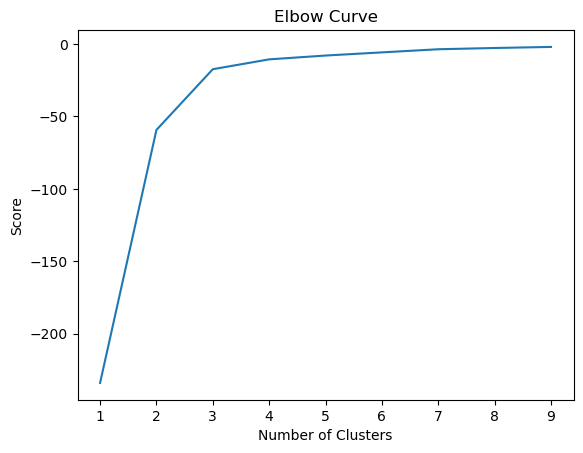

In [26]:
# Plot the elbow curve using PyLab.

pl.plot(num_cl,scores)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

The graph shows a bend in the curve at 3 clusters. 3 clusters could suggest that the counties can be grouped into high density counties with large number of EVs & EVCS, low density counties with low numbers of EVs and EVCS, and a third group that is in-between both extremes.

### 3. k-means clustering 

In [27]:
# Step 1: Generate cluster_labels
# Create the k-means object.

kmeans = KMeans(n_clusters = 3) 
cluster_labels = kmeans.fit_predict(df_selected_standardized)

C:\Users\Caroline\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Caroline\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [28]:
# Step 2: Convert the cluster_labels to a pandas Series
cluster_labels_series = pd.Series(cluster_labels)

In [29]:
# Step 3: Convert df_selected_standardized back to a DataFrame (if needed)
# If df_selected_standardized is already a DataFrame, skip this step.
df_selected_standardized = pd.DataFrame(df_selected_standardized)

In [30]:
# Step 4: Assign the Series to a new column in the DataFrame
df_selected_standardized['clusters'] = cluster_labels_series

In [31]:
df_selected_standardized.head()

,0,1,2,3,4,5,clusters
0,-0.285385,-0.439167,-0.562016,-0.449728,-0.300553,-0.286184,0
1,-0.297869,-0.464644,-0.463578,-0.445834,-0.299145,-0.458189,0
2,-0.179266,0.186762,-0.112994,0.033113,-0.155535,-0.171515,0
3,-0.085631,-0.353088,-0.495773,-0.301312,-0.233940,0.134271,0
4,-0.123085,-0.347787,-0.425719,-0.306651,-0.230948,-0.018622,0


In [32]:
df_selected_standardized['clusters'].value_counts()

0    32
2     6
1     1
Name: clusters, dtype: int64

In [33]:
#To add the clusters column to the non-standardized data
# Extract the 'clusters' column from df_selected_standardized
clusters = df_selected_standardized['clusters']

In [34]:
# Create a copy of df_selected to avoid modifying the original DataFrame
df_clustered = df_selected.copy()

In [35]:
# Assign the 'clusters' Series to the 'clusters' column in the DataFrame
df_clustered['clusters'] = clusters.values
# Now, df_clustered contains the original data along with the 'clusters' column

In [36]:
df_clustered.head()

,evcs_sum,00-20 popchange,popdensity,CountyPop_22,EV_co_curr,L3cs_sum_county,clusters
0,3,4186,10.707657,20961,39,9.0,0
3,1,1735,35.032293,22508,55,0.0,0
4,20,64402,121.664050,212791,1687,15.0,0
24,35,12467,27.076639,79926,796,31.0,0
59,29,12977,44.387454,77805,830,23.0,0


In [37]:
df_clustered['clusters'].value_counts()

0    32
2     6
1     1
Name: clusters, dtype: int64

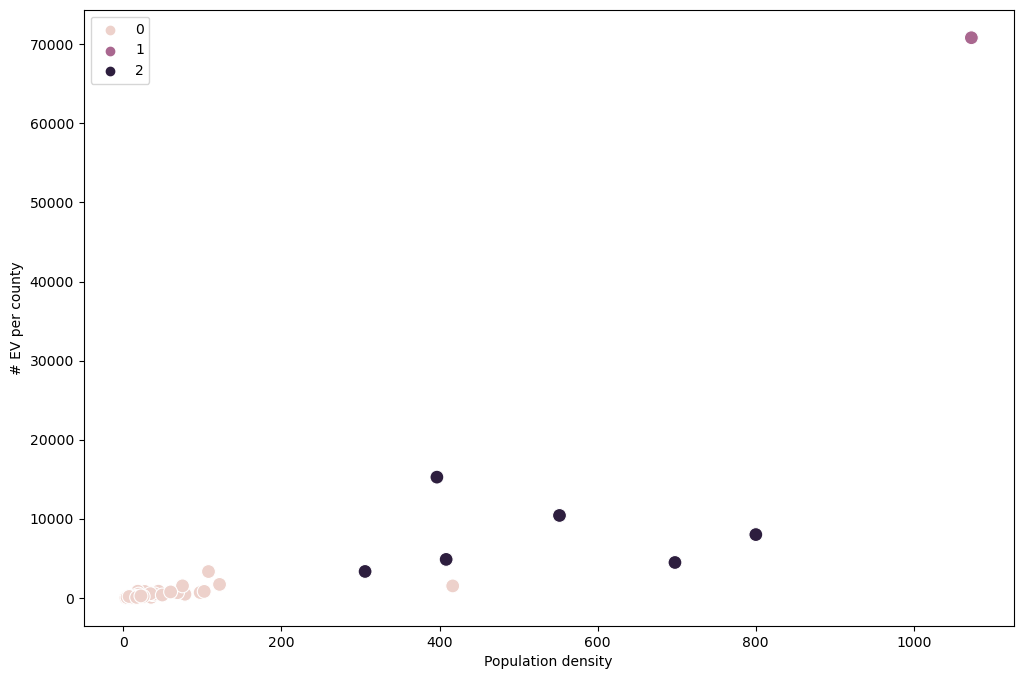

In [38]:
# Plot the 3 clusters for the "EV_co_curr" and "popdensity" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(y=df_clustered['EV_co_curr'], x=df_clustered['popdensity'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.ylabel('# EV per county') # Label y-axis.
plt.xlabel('Population density') # Label x-axis.
plt.show()

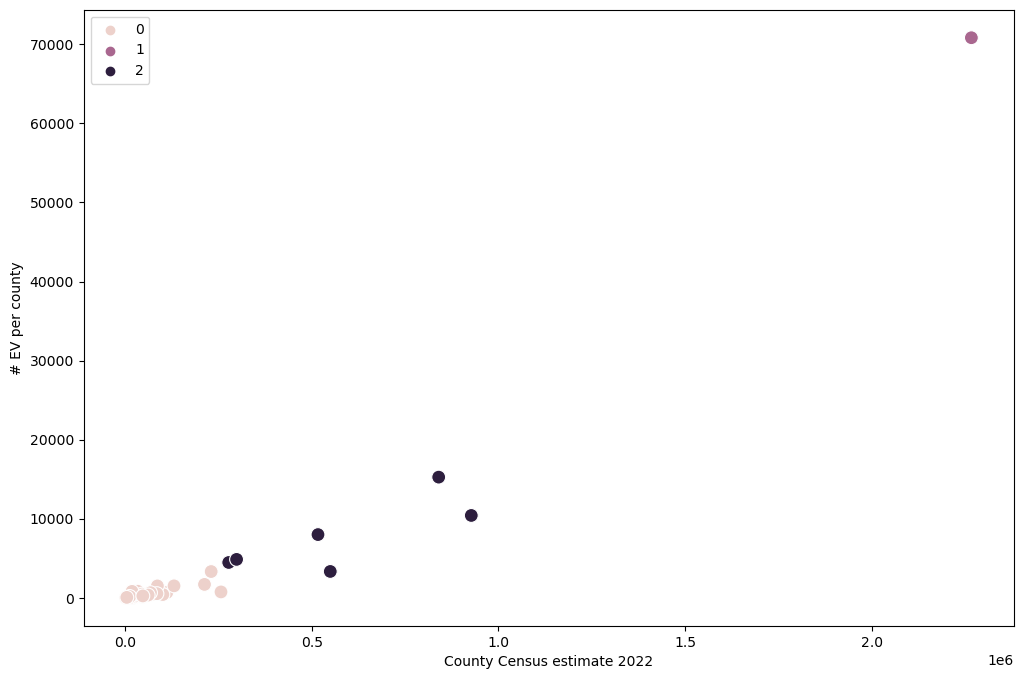

In [39]:
# Plot the 3 clusters for the "CountyPop_22" and "EV_co_curr" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(y=df_clustered['EV_co_curr'], x=df_clustered['CountyPop_22'], hue=kmeans.labels_, s=100) 

ax.grid(False) 
plt.ylabel('# EV per county') 
plt.xlabel('County Census estimate 2022') 
plt.show()

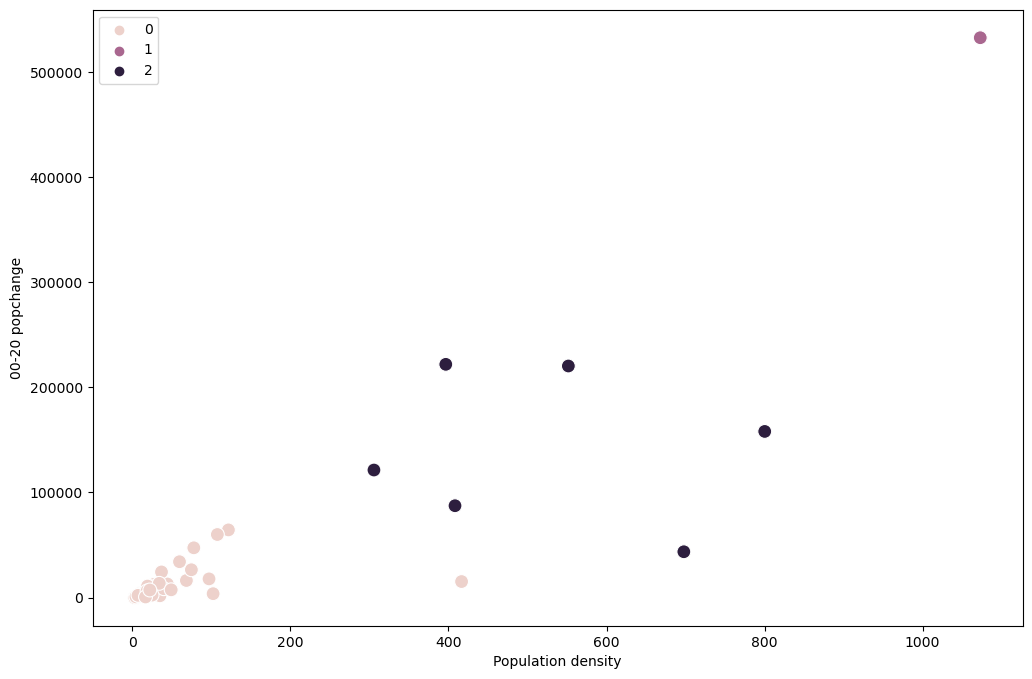

In [40]:
# Plot the 3 clusters for the "popdensity" and "00-20 popchange" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_clustered['popdensity'], y=df_clustered['00-20 popchange'], hue=kmeans.labels_, s=100) 

ax.grid(False) 
plt.xlabel('Population density') 
plt.ylabel('00-20 popchange') 
plt.show()

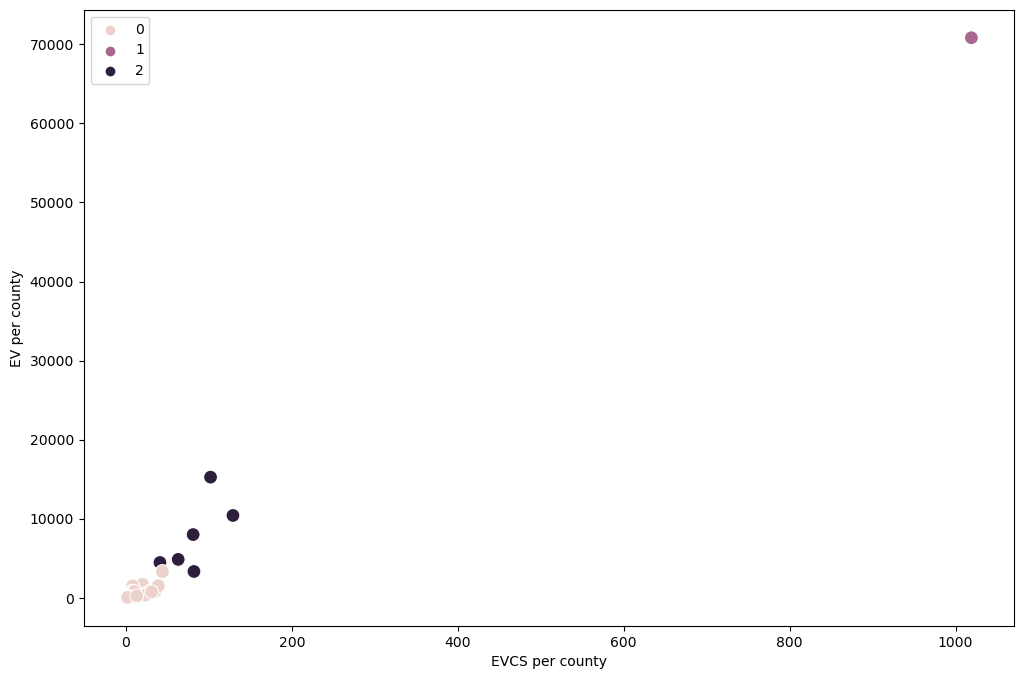

In [41]:
# Plot the 3 clusters for the "evcs_sum" and "EV_co_curr" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_clustered['evcs_sum'], y=df_clustered['EV_co_curr'], hue=kmeans.labels_, s=100) 

ax.grid(False) 
plt.xlabel('EVCS per county') 
plt.ylabel('EV per county') 
plt.show()

- The 3 clusters seem to be influenced by the census population and the number of EV and EVCS per county. The clusters do not quite align with population density and that could be related to the low amount of population growth in this county. These clusters are based on an extremely small dataset.

### 4. Descriptive statistics - clusters 

In [42]:
df_clustered.loc[df_clustered['clusters'] == 2, 'cluster'] = 'dark purple'
df_clustered.loc[df_clustered['clusters'] == 1, 'cluster'] = 'purple'
df_clustered.loc[df_clustered['clusters'] == 0, 'cluster'] = 'pink'

In [43]:
df_clustered.groupby('cluster').agg({'evcs_sum':['mean', 'median'], 
                                     'popdensity':['mean', 'median'], 
                                     '00-20 popchange':['mean', 'median'],
                                     'CountyPop_22':['mean', 'median'],
                                     'EV_co_curr' : ['mean', 'median'],
                                     'L3cs_sum_county' : ['mean', 'median']})

evcs_sum           popdensity              00-20 popchange  \
                   mean  median         mean       median            mean   
cluster                                                                     
dark purple    83.00000    81.5   526.753334   480.034764   142115.166667   
pink           11.96875     8.0    50.014800    26.064350    13302.593750   
purple       1019.00000  1019.0  1072.841254  1072.841254   532592.000000   

                       CountyPop_22               EV_co_curr           \
               median          mean     median          mean   median   
cluster                                                                 
dark purple  139719.0  5.683932e+05   533234.5   7716.166667   6421.0   
pink           7319.0  6.589494e+04    46404.0    549.593750    376.5   
purple       532592.0  2.266789e+06  2266789.0  70842.000000  70842.0   

            L3cs_sum_county         
                       mean median  
cluster                             
dark purple       50.000000   46.5  
pink              10.533333    1.5  
purple           319.000000  319.0

The dark purple cluster seems to represent counties with a higher number of EV charging stations, moderate population density, a growing population, a high number of electric vehicles, and a substantial number of Level 3 charging ports.

The pink cluster appears to represent counties with a lower number of EV charging stations, lower population density, low population growth, a small number of electric vehicles, and few Level 3 charging ports per county.

The purple cluster represents one county with a significantly high number of EV charging stations, high population density, high population growth, a very high number of electric vehicles, and a substantial number of Level 3 charging ports.

The clusters exhibit distinct characteristics in terms of EVCS, EV, population density, and population growth.


- These results can be used to compare growth rate of EV registrations and the rate of population growth for each cluster. This could help determine if the trend of growth rate of EV registration outpacing the population growth rate holds true for all counties or is more prevalent in some clusters.

The growth rate of EV registration over time could also be analyzed by cluster instead of by individual counties. Clustering the counties could also help to explore the relationship between EV registrations per person and the number of EVCS in a county.

The clusters could also be useful for predictive modeling to forecast future EV registrations and resource allocations for vehicle charging infrastructure. 

### 5. Add cluster data and export

In [44]:
# Count the number of unique values in the 'CountyPop_22' column of df_present to check if can merge on CountyPop_22
df_present['CountyPop_22'].nunique()

39

In [45]:
# Create a mapping dictionary for cluster values
cluster_mapping = {2: 'medium', 1: 'high', 0: 'low'}

In [46]:
# Add the cluster values using the mapping dictionary
df_clustered['cluster_category'] = df_clustered['clusters'].replace(cluster_mapping)

In [47]:
df_clustered.head()

,evcs_sum,00-20 popchange,popdensity,CountyPop_22,EV_co_curr,L3cs_sum_county,clusters,cluster,cluster_category
0,3,4186,10.707657,20961,39,9.0,0,pink,low
3,1,1735,35.032293,22508,55,0.0,0,pink,low
4,20,64402,121.664050,212791,1687,15.0,0,pink,low
24,35,12467,27.076639,79926,796,31.0,0,pink,low
59,29,12977,44.387454,77805,830,23.0,0,pink,low


In [48]:
# Create a new DataFrame with CountyPop_22 and the cluster_category variable from df_clustered
cluster_data = df_clustered[['CountyPop_22', 'cluster_category']]

In [49]:
# Merge the cluster data into df_present based on Countypop_22
df_merged = df_present.merge(cluster_data, on='CountyPop_22', how='left')

In [50]:
df_merged.head(10)

,Station Name,City,County,Latitude,Longitude,EV Level1,EV Level2,EV Level3,Open Date2,evcs_sum,...,CountyPop_22,Area sq mi,popdensity,density flag,00-20 popchange,20-22 popchange,EV_co_curr,Year,Month,cluster_category
0,Best Western Plus Bronco Inn - Tesla Supercharger,Ritzville,Adams,47.116294,-118.368328,0,0,4,2014-06-15,3,...,20961,1924.977566,10.707657,low density,4186,349,39,2014,6,low
1,Cow Creek Mercantile,Ritzville,Adams,47.119480,-118.362710,0,0,4,2019-08-22,3,...,20961,1924.977566,10.707657,low density,4186,349,39,2019,8,low
2,Conoco,Ritzville,Adams,47.118605,-118.365561,0,0,1,2018-03-07,3,...,20961,1924.977566,10.707657,low density,4186,349,39,2018,3,low
3,Port of Clarkston,Clarkston,Asotin,46.425498,-117.048650,0,2,0,2017-05-01,1,...,22508,636.212991,35.032293,low density,1735,220,55,2017,5,low
4,Hamilton Cellars - Tesla Destination,Benton City,Benton,46.296071,-119.451487,0,3,0,2015-07-14,20,...,212791,1700.379029,121.664050,medium density,64402,5916,1687,2015,7,low
5,Leskovar Mitsubishi,Kennewick,Benton,46.213233,-119.162367,0,3,0,2014-03-01,20,...,212791,1700.379029,121.664050,medium density,64402,5916,1687,2014,3,low
6,Kennewick,Kennewick,Benton,46.180363,-119.188501,0,1,1,2018-06-14,20,...,212791,1700.379029,121.664050,medium density,64402,5916,1687,2018,6,low
7,Fred Meyer - Tesla Supercharger,Kennewick,Benton,46.198035,-119.162687,0,0,8,2015-08-01,20,...,212791,1700.379029,121.664050,medium density,64402,5916,1687,2015,8,low
8,Badger Mountain Vineyard & Powers Winery - Tes...,Kennewick,Benton,46.213187,-119.286497,0,3,0,2017-07-27,20,...,212791,1700.379029,121.664050,medium density,64402,5916,1687,2017,7,low
9,Hampton Inn Kennewick at Southridge - Tesla De...,Kennewick,Benton,46.178019,-119.189427,0,2,0,2016-02-08,20,...,212791,1700.379029,121.664050,medium density,64402,5916,1687,2016,2,low


In [51]:
#no NaN - good
df_merged['cluster_category'].value_counts()

high      1019
medium     498
low        385
Name: cluster_category, dtype: int64

In [52]:
#Export df_merged in .pkl format
df_merged.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'WA_present_cluster.pkl'))

In [53]:
#Export df_merged & df_hist in .csv format
df_merged.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'WA_present_cluster.csv'))
df_hist.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'WA_hist.csv'))
